<a href="https://colab.research.google.com/github/Olesiewitch/Predictive_Analytics/blob/master/EconML_CATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Main imports 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})

#import for econml 

!pip install econml
from econml.metalearners import TLearner, SLearner, XLearner

from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 110.5MB 44kB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 6.7MB 37.6MB/s 
     |████████████████████████████████| 512kB 43.4MB/s 
     |████████████████████████████████| 3.8MB 41.4MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=49cd1eeb5eb57b3a9946bcf35fcd0429a0a1a22f28254ad0ea88a068d9acf96b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: sparse 0.10.0 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfu

##**Data Generation for CATE Estimation**

In [2]:
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

# controls outcome, treatment effect, propensity definitions
def generate_controls_outcome(d):
    beta = uniform(-5, 5, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)


#true treatment effect depends on value of x1
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8  
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [3]:
# DGP constants and test data (d = 20)
d = 20
n = 10000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

##**Metalearners & EconML**

In [4]:
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))

In [5]:
# T learner
T_learner = TLearner(models)
T_learner.fit(Y, T, X)
T_te = T_learner.effect(X_test)

In [6]:
# S learner
S_learner = SLearner(models)
S_learner.fit(Y, T, X)
S_te = S_learner.effect(X_test)

In [7]:
# X learner 
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100),
                                                  class_weight='balanced_subsample')
X_learner = XLearner(models=models, propensity_model=propensity_model)
X_learner.fit(Y, T, X)
X_te = X_learner.effect(X_test)

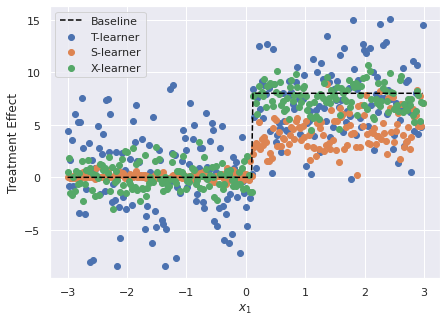

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], T_te, label="T-learner")
plt.scatter(X_test[:, 1], S_te, label="S-learner")
plt.scatter(X_test[:, 1], X_te, label="X-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

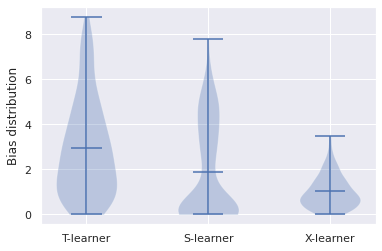

In [9]:
exp_te = np.apply_along_axis(treatment_effect, 1, X_test)
plt.violinplot([np.abs(T_te - exp_te), 
                np.abs(S_te - exp_te),
                np.abs(X_te - exp_te),
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3], ['T-learner', 'S-learner', 'X-learner'])
plt.show()